[*********************100%%**********************]  1 of 1 completed
Model is not converging.  Current: 7631.891582903856 is not greater than 7634.564196262193. Delta is -2.672613358337003


Model Score:  7627.052340504314


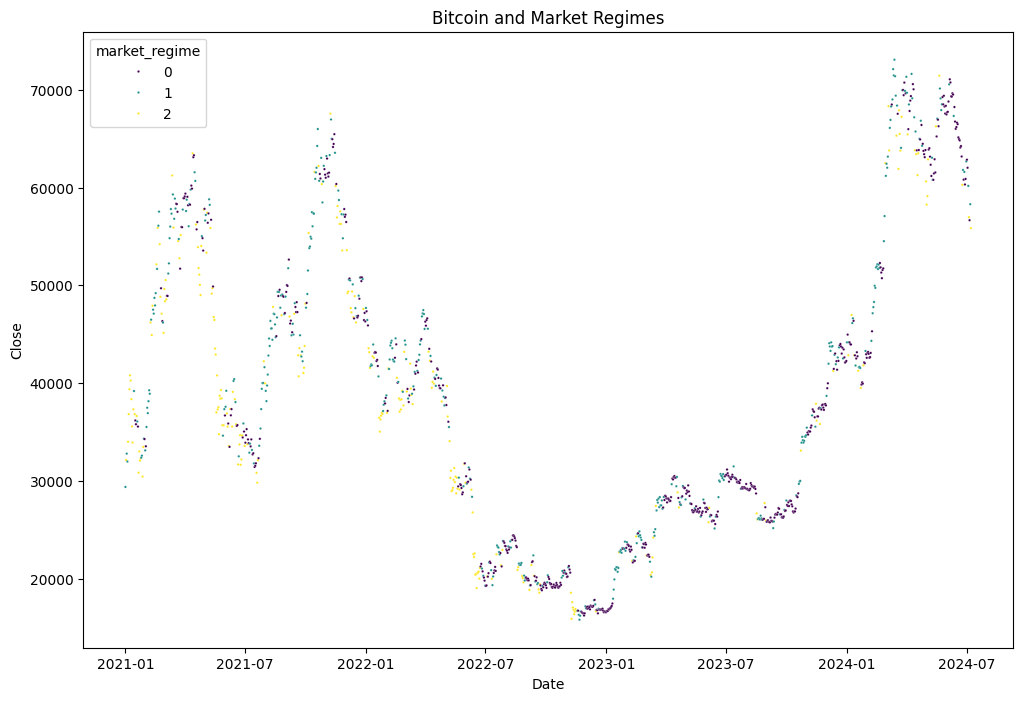

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import johnsonsu, skew, kurtosis
import warnings
from random import sample
# PREPARING DATA

data = yf.download('BTC-USD', interval='1d')
data['dollar_volume'] = data['Volume'] * data['Close']
data['log_returns'] = np.log(data['Close']/data['Close'].shift(1))
data['forward_returns'] = data['log_returns'].shift(-1)
data['momentum'] = np.log(data['Close']/data['Close'].shift(10))
data.dropna(inplace=True)
training_data = data.copy().loc[:'2021-01-01']
testing_data = data.copy().loc['2021-01-01':]

np.random.seed(0)

features = ['log_returns', 'momentum']

# TRAINING + VERIFYING HMM

hmm_model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, tol=1, algorithm='map')
hmm_model.fit(np.array(training_data[features]))
print("Model Score: ", hmm_model.score(np.array(training_data[features])))


In [ ]:
# PLOTTING PREDICTED MARKET REGIMES

testing_data.loc[:, 'market_regime'] = hmm_model.predict(np.array(testing_data[features]))
testing_data.loc[:, 'market_regime'] = hmm_model.predict(np.array(testing_data[features]))

plt.figure(figsize=(12, 8))
sns.scatterplot(x=testing_data.index, y='Close', hue='market_regime', data=testing_data, s=3, palette='viridis')
plt.title('Bitcoin and Market Regimes')
plt.show()

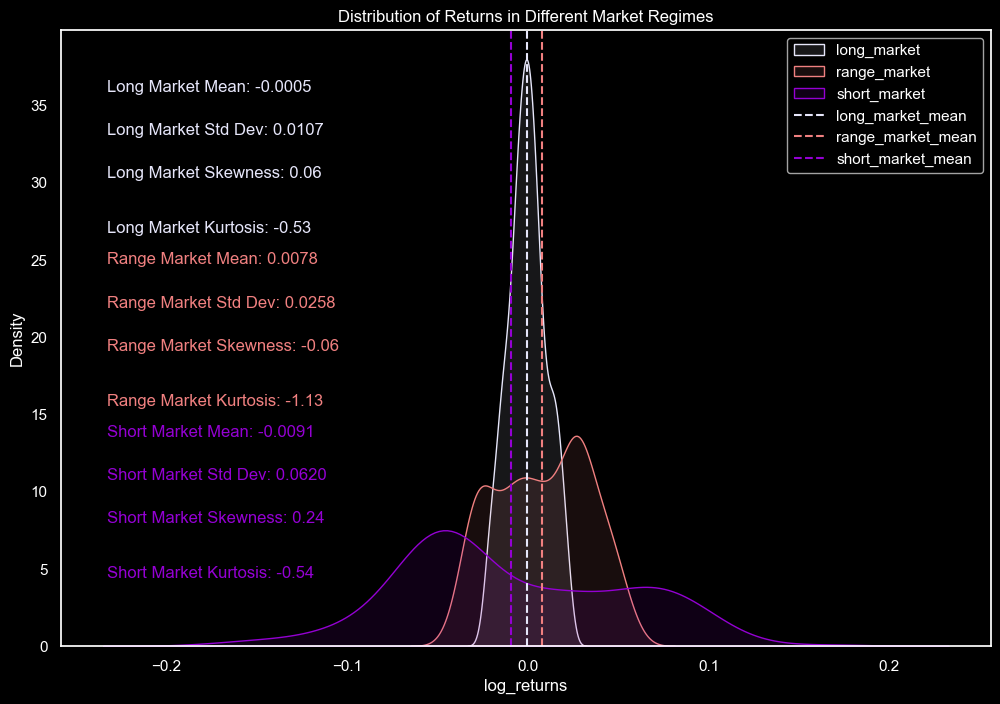

In [78]:
# PLOTTING LOG RETURNS UNDER DIFFERENT PREDICTED MARKET REGIMES

long_market = testing_data[testing_data['market_regime'] == 0]
short_market = testing_data[testing_data['market_regime'] == 2]
range_market = testing_data[testing_data['market_regime'] == 1]

sns.set_theme(style="dark", rc={"axes.grid": False})

plt.style.use('dark_background')

plt.figure(figsize=(12,8))
sns.kdeplot(long_market['log_returns'], label='long_market', color='lavender', fill=True, alpha=0.1)
sns.kdeplot(range_market['log_returns'], label='range_market', color='lightcoral', fill=True, alpha=0.1)
sns.kdeplot(short_market['log_returns'], label='short_market', color='darkviolet', fill=True, alpha=0.1)
plt.axvline(long_market['log_returns'].mean(), color='lavender', linestyle='--', label='long_market_mean')
plt.axvline(range_market['log_returns'].mean(), color='lightcoral', linestyle='--', label='range_market_mean')
plt.axvline(short_market['log_returns'].mean(), color='darkviolet', linestyle='--', label='short_market_mean')

y_cord = 0.90
delt = 0.07
for market, color, label in [(long_market, 'lavender', 'Long'), (range_market, 'lightcoral', 'Range'), (short_market, 'darkviolet', 'Short')]:
    # Computing statistics 
    mean = market['log_returns'].mean()
    std_dev = market['log_returns'].std()
    skewness = skew(market['log_returns'])
    kurt = kurtosis(market['log_returns'])

    plt.annotate(f'{label} Market Mean: {mean:.4f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    plt.annotate(f'{label} Market Std Dev: {std_dev:.4f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    
    plt.annotate(f'{label} Market Skewness: {skewness:.2f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color)
    y_cord -= delt
    plt.annotate(f'{label} Market Kurtosis: {kurt:.2f}', xy=(0.05, y_cord), xycoords='axes fraction', color=color, verticalalignment='top')
    y_cord -= delt

plt.legend()
plt.title('Distribution of Returns in Different Market Regimes')

plt.show()